TRAINING STANDARD NEURAL NETWORK
Loaded 50000 rows with MC Dropout predictions
Epoch 20/150: Train Loss: 1.7703, Val Loss: 2.3822
Epoch 40/150: Train Loss: 1.0480, Val Loss: 0.3990
Epoch 60/150: Train Loss: 0.9742, Val Loss: 0.3003
Epoch 80/150: Train Loss: 0.8219, Val Loss: 0.4181
Epoch 100/150: Train Loss: 0.7441, Val Loss: 0.3368
Epoch 120/150: Train Loss: 0.5531, Val Loss: 0.2754
Early stopping at epoch 121

CREATING RESIDUAL PLOT WITH BOTH MODELS


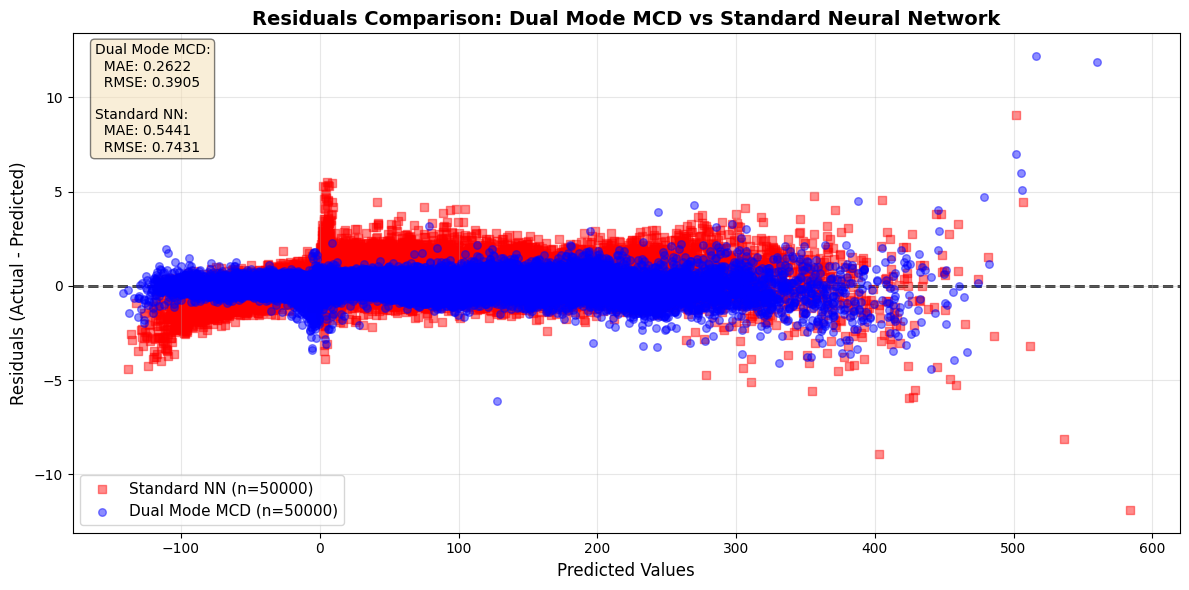


✓ Saved residual comparison plot to: comparison_results\residuals_comparison_plot.png


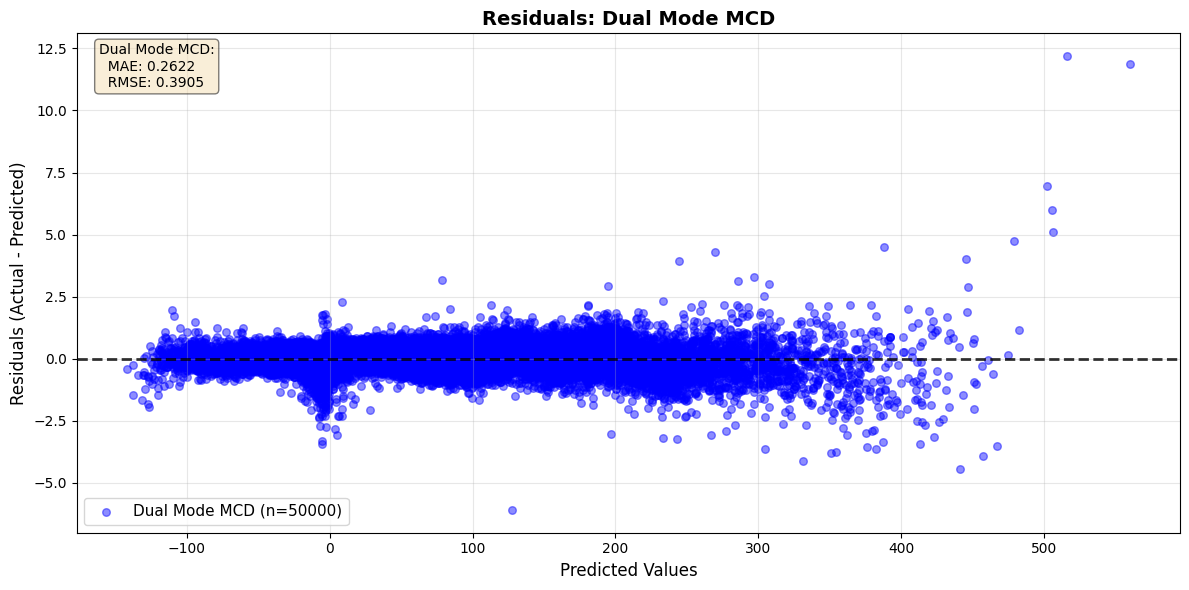


✓ Saved Dual Mode MCD residual plot to: comparison_results\residuals_dual_mode_mcd.png


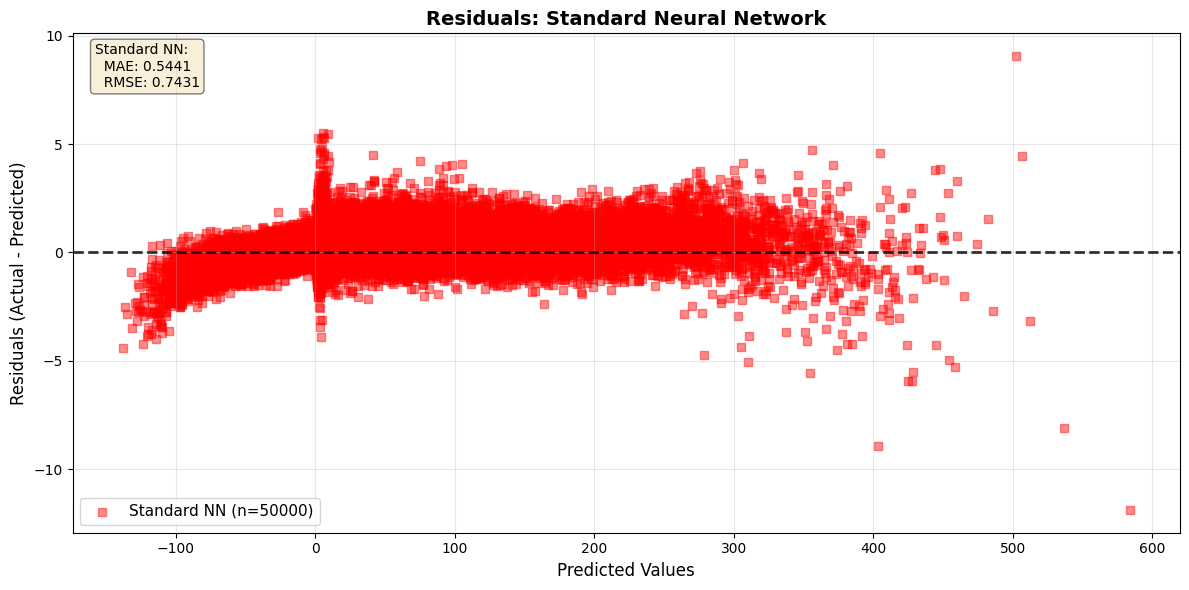


✓ Saved Standard NN residual plot to: comparison_results\residuals_standard_nn.png

MODEL COMPARISON METRICS

MC Dropout Model:
  MAE:  0.2622
  RMSE: 0.3905
  R²:   1.0000

Standard Neural Network:
  MAE:  0.5441
  RMSE: 0.7431
  R²:   0.9999

✓ Saved all predictions to: comparison_results\all_predictions_comparison.csv



In [ ]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


TRAIN_CSV = "data_rpm_with_predictions_residuals.csv"  # From your MC Dropout model
FEATURES = [
    "mass",
    "rolling_resistance_coefficient",
    "drag_coefficient",
    "frontal_area",
    "slope_percent",
    "wheel_diameter",
    "reduction_ratio",
    "drivetrain_efficiency",
    "velocity",
    "distance",
    "battery_efficiency",
]

TARGET = "net_energy_kwh"

EPOCHS = 150
BATCH_SIZE = 32
LR = 1e-3
TEST_SIZE = 0.2
RANDOM_STATE = 42

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

class StandardMLP(nn.Module):
    def __init__(self, in_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.net(x)

def main():
    print("="*60)
    print("TRAINING STANDARD NEURAL NETWORK")
    print("="*60)
    
    # ----- Load data with MC Dropout predictions
    df = pd.read_csv(TRAIN_CSV)
    
    if f"{TARGET}_predicted" not in df.columns or f"{TARGET}_residual" not in df.columns:
        print("ERROR: CSV doesn't have MC Dropout predictions!")
        print(f"Expected columns: '{TARGET}_predicted' and '{TARGET}_residual'")
        print("Make sure to run your MC Dropout model first.")
        return
    
    # Get MC Dropout predictions and residuals
    mc_pred = df[f"{TARGET}_predicted"].values
    mc_residual = df[f"{TARGET}_residual"].values
    y_true = df[TARGET].values
    
    print(f"Loaded {len(df)} rows with MC Dropout predictions")
    
    # ----- Train Standard NN
    X = df[FEATURES].to_numpy(dtype=np.float32)
    y = df[TARGET].to_numpy(dtype=np.float32)
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )
    
    # Scale
    x_scaler = StandardScaler()
    X_train_s = x_scaler.fit_transform(X_train)
    X_test_s = x_scaler.transform(X_test)
    
    # Train model
    model = StandardMLP(in_dim=X_train_s.shape[1]).to(DEVICE)
    train_loader = DataLoader(
        TensorDataset(
            torch.tensor(X_train_s, dtype=torch.float32),
            torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
        ),
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    
    val_loader = DataLoader(
        TensorDataset(
            torch.tensor(X_test_s, dtype=torch.float32),
            torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)
        ),
        batch_size=BATCH_SIZE,
        shuffle=False
    )
    
    # Training loop
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.MSELoss()
    
    best_val_loss = float('inf')
    patience = 20
    patience_counter = 0
    
    for epoch in range(EPOCHS):
        # Training
        model.train()
        train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                pred = model(xb)
                loss = loss_fn(pred, yb)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS}: Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # ----- Generate predictions for ALL data
    X_all_scaled = x_scaler.transform(X)
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X_all_scaled, dtype=torch.float32).to(DEVICE)
        nn_pred = model(X_tensor).cpu().numpy().flatten()
    
    # Calculate residuals for Standard NN
    nn_residual = y_true - nn_pred
    
    # ----- SINGLE RESIDUAL PLOT WITH BOTH MODELS
    print("\n" + "="*60)
    print("CREATING RESIDUAL PLOT WITH BOTH MODELS")
    print("="*60)
    
    # Calculate and display metrics in plot
    mc_mae = mean_absolute_error(y_true, mc_pred)
    nn_mae = mean_absolute_error(y_true, nn_pred)
    mc_rmse = np.sqrt(mean_squared_error(y_true, mc_pred))
    nn_rmse = np.sqrt(mean_squared_error(y_true, nn_pred))
    
    # ---- Combined plot (blue over red)
    plt.figure(figsize=(12, 6))
    
    # Plot Standard NN residuals (below)
    plt.scatter(nn_pred, nn_residual, 
                alpha=0.45, s=30, color='red', 
                label=f'Standard NN (n={len(nn_pred)})',
                marker='s', zorder=1)
    
    # Plot Dual Mode MCD residuals (above)
    plt.scatter(mc_pred, mc_residual, 
                alpha=0.45, s=30, color='blue', 
                label=f'Dual Mode MCD (n={len(mc_pred)})',
                marker='o', zorder=2)
    
    # Perfect prediction line
    plt.axhline(y=0, color='black', linestyle='--', linewidth=2, alpha=0.8, zorder=0)
    
    # Labels and title
    plt.xlabel('Predicted Values', fontsize=12)
    plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
    plt.title('Residuals Comparison: Dual Mode MCD vs Standard Neural Network', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    textstr = '\n'.join((
        f'Dual Mode MCD:',
        f'  MAE: {mc_mae:.4f}',
        f'  RMSE: {mc_rmse:.4f}',
        f'',
        f'Standard NN:',
        f'  MAE: {nn_mae:.4f}',
        f'  RMSE: {nn_rmse:.4f}'
    ))
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    
    # Save the plot
    os.makedirs('comparison_results', exist_ok=True)
    plot_path = os.path.join('comparison_results', 'residuals_comparison_plot.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Saved residual comparison plot to: {plot_path}")
    
    # ---- Separate plot: Dual Mode MCD only
    plt.figure(figsize=(12, 6))
    
    plt.scatter(mc_pred, mc_residual, 
                alpha=0.45, s=30, color='blue', 
                label=f'Dual Mode MCD (n={len(mc_pred)})',
                marker='o')
    
    plt.axhline(y=0, color='black', linestyle='--', linewidth=2, alpha=0.8)
    
    plt.xlabel('Predicted Values', fontsize=12)
    plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
    plt.title('Residuals: Dual Mode MCD', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    textstr_mcd = '\n'.join((
        f'Dual Mode MCD:',
        f'  MAE: {mc_mae:.4f}',
        f'  RMSE: {mc_rmse:.4f}'
    ))
    plt.text(0.02, 0.98, textstr_mcd, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    
    plot_path_mcd = os.path.join('comparison_results', 'residuals_dual_mode_mcd.png')
    plt.savefig(plot_path_mcd, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Saved Dual Mode MCD residual plot to: {plot_path_mcd}")
    
    # ---- Separate plot: Standard NN only
    plt.figure(figsize=(12, 6))
    
    plt.scatter(nn_pred, nn_residual, 
                alpha=0.45, s=30, color='red', 
                label=f'Standard NN (n={len(nn_pred)})',
                marker='s')
    
    plt.axhline(y=0, color='black', linestyle='--', linewidth=2, alpha=0.8)
    
    plt.xlabel('Predicted Values', fontsize=12)
    plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
    plt.title('Residuals: Standard Neural Network', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    textstr_nn = '\n'.join((
        f'Standard NN:',
        f'  MAE: {nn_mae:.4f}',
        f'  RMSE: {nn_rmse:.4f}'
    ))
    plt.text(0.02, 0.98, textstr_nn, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    
    plot_path_nn = os.path.join('comparison_results', 'residuals_standard_nn.png')
    plt.savefig(plot_path_nn, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Saved Standard NN residual plot to: {plot_path_nn}")
    
    # ----- Print metrics
    print("\n" + "="*60)
    print("MODEL COMPARISON METRICS")
    print("="*60)
    
    print("\nMC Dropout Model:")
    print(f"  MAE:  {mc_mae:.4f}")
    print(f"  RMSE: {mc_rmse:.4f}")
    print(f"  R²:   {r2_score(y_true, mc_pred):.4f}")
    
    print("\nStandard Neural Network:")
    print(f"  MAE:  {nn_mae:.4f}")
    print(f"  RMSE: {nn_rmse:.4f}")
    print(f"  R²:   {r2_score(y_true, nn_pred):.4f}")
    
    # ----- Save predictions to CSV
    results_df = df.copy()
    results_df[f'{TARGET}_standard_predicted'] = nn_pred
    results_df[f'{TARGET}_standard_residual'] = nn_residual
    
    csv_path = os.path.join('comparison_results', 'all_predictions_comparison.csv')
    results_df.to_csv(csv_path, index=False)
    
    print(f"\n✓ Saved all predictions to: {csv_path}")
    print("\n" + "="*60)

if __name__ == "__main__":
    main()


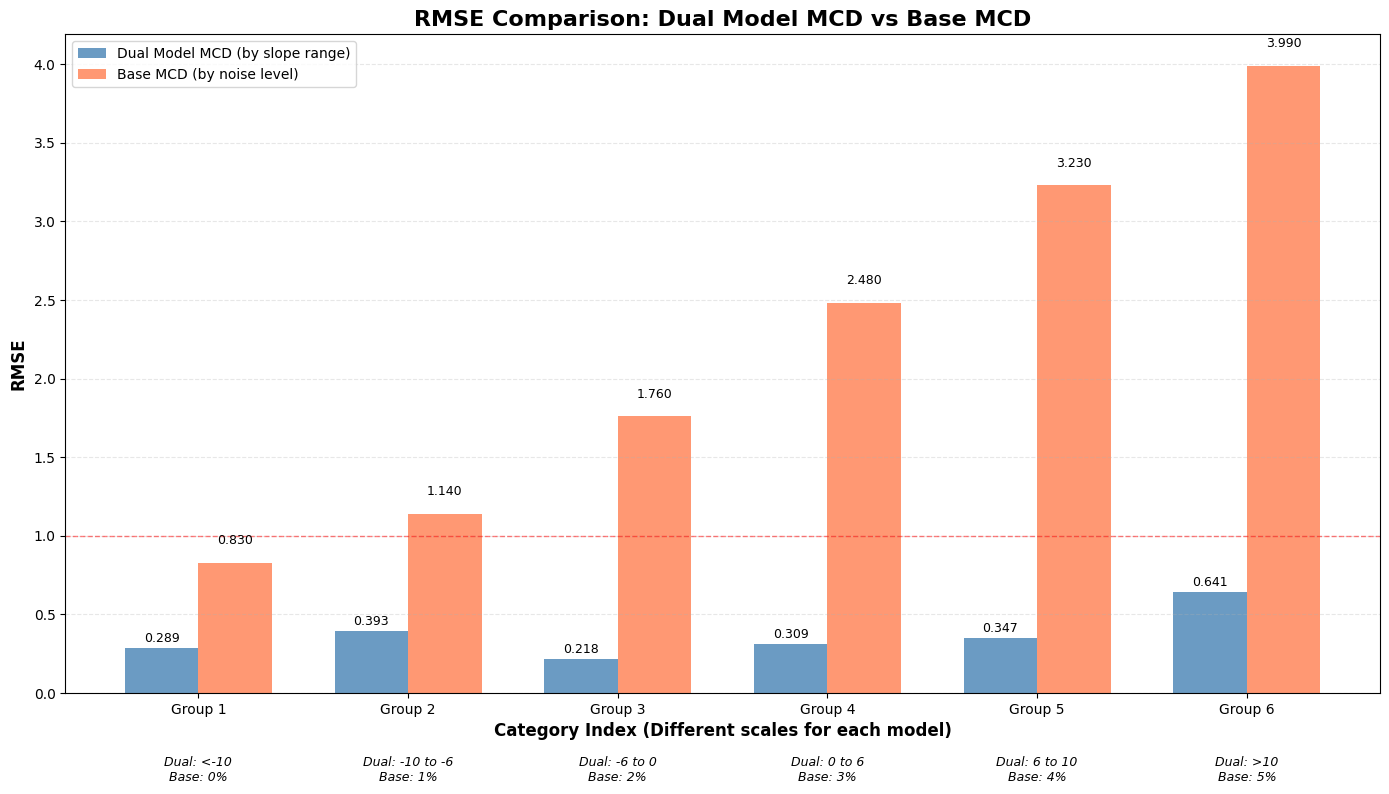

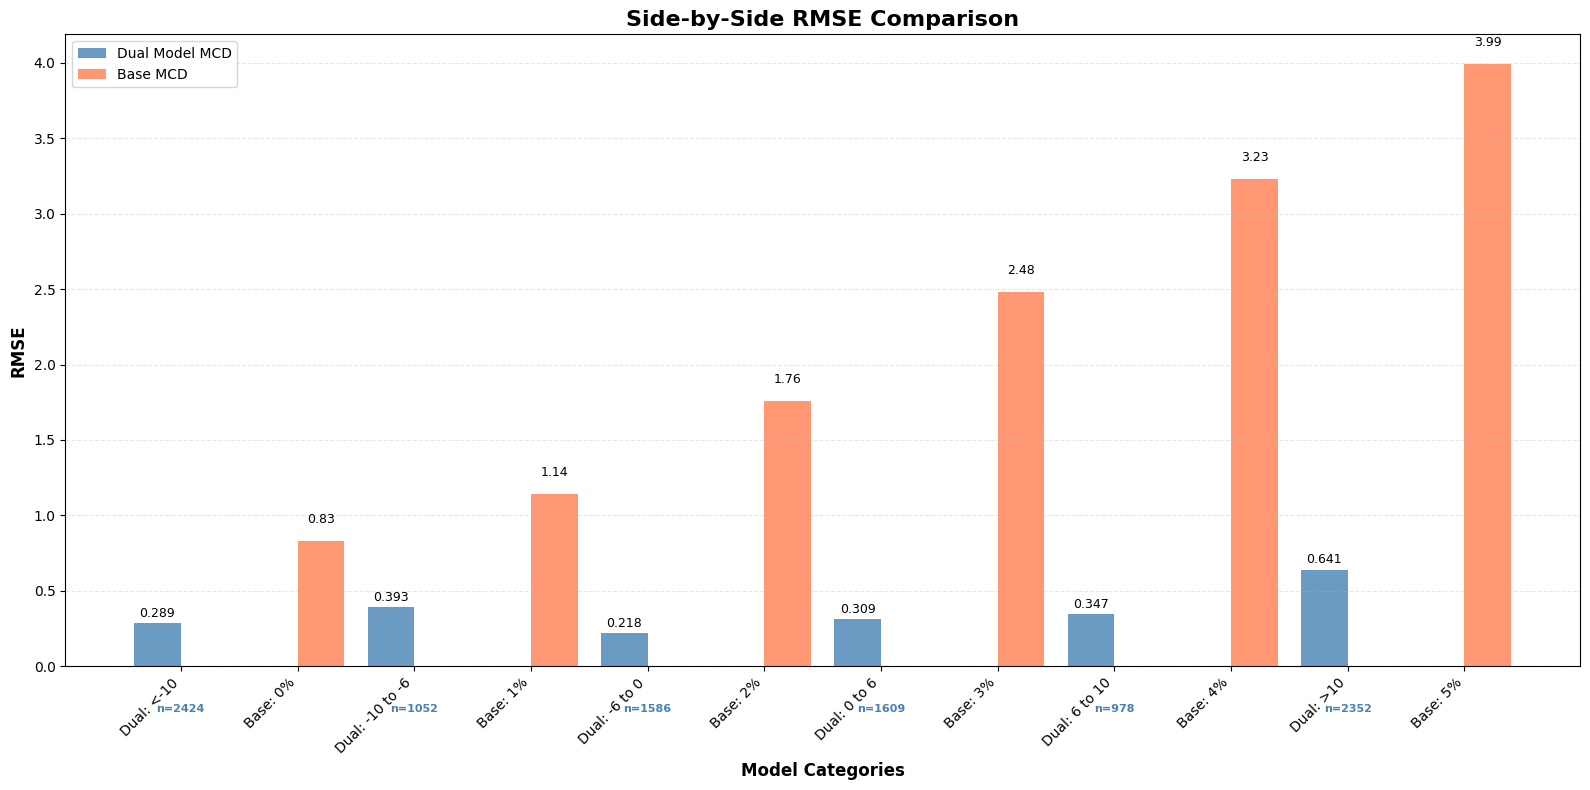

RMSE COMPARISON TABLE
Group           Dual Model   Base Model   Difference  
                (Slope)      (Noise)      (Base - Dual)
------------------------------------------------------------
1               0.2890       0.830        0.541       
2               0.3926       1.140        0.747       
3               0.2177       1.760        1.542       
4               0.3094       2.480        2.171       
5               0.3474       3.230        2.883       
6               0.6406       3.990        3.349       
Average         0.3661       2.238        1.872       


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data for DUAL MODEL MCD (by slope range)
dual_categories = ['<-10', '-10 to -6', '-6 to 0', '0 to 6', '6 to 10', '>10']
dual_samples = [2424, 1052, 1586, 1609, 978, 2352]
dual_rmse = [0.2890, 0.3926, 0.2177, 0.3094, 0.3474, 0.6406]

# Data for BASE MCD (by noise level)
base_categories = ['0%', '1%', '2%', '3%', '4%', '5%']
base_rmse = [0.830, 1.14, 1.76, 2.48, 3.23, 3.99]

# Since we have different x-axis categories, we'll use indices
x = np.arange(len(dual_categories))
width = 0.35  # Width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Create bars for both models
bars1 = ax.bar(x - width/2, dual_rmse, width, 
               color='steelblue', alpha=0.8, label='Dual Model MCD (by slope range)')
bars2 = ax.bar(x + width/2, base_rmse[:len(x)], width, 
               color='coral', alpha=0.8, label='Base MCD (by noise level)')

# Customize the plot
ax.set_xlabel('Category Index (Different scales for each model)', fontsize=12, fontweight='bold')
ax.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax.set_title('RMSE Comparison: Dual Model MCD vs Base MCD', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'Group {i+1}' for i in range(len(x))])
ax.legend()
ax.grid(True, alpha=0.3, linestyle='--', axis='y')

# Add value labels on top of bars
def autolabel(bars, values, offset=0.02):
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + offset,
                f'{value:.3f}', ha='center', va='bottom', fontsize=9)

autolabel(bars1, dual_rmse, 0.02)
autolabel(bars2, base_rmse[:len(x)], 0.1)

# Add category information as text annotations
for i, (dual_cat, base_cat) in enumerate(zip(dual_categories, base_categories)):
    ax.text(i, -0.4, f'Dual: {dual_cat}\nBase: {base_cat}', 
            ha='center', va='top', fontsize=9, style='italic')

# Add a horizontal line at y=1.0 for reference
ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.show()

# Alternative: Create a grouped plot with actual category names
fig2, ax2 = plt.subplots(figsize=(16, 8))

# We'll use actual category names with proper grouping
all_categories = []
all_rmse_dual = []
all_rmse_base = []

for i, dual_cat in enumerate(dual_categories):
    all_categories.append(f'Dual: {dual_cat}')
    all_categories.append(f'Base: {base_categories[i]}')
    all_rmse_dual.extend([dual_rmse[i], np.nan])  # Dual value, then empty for base
    all_rmse_base.extend([np.nan, base_rmse[i]])  # Empty for dual, then base value

x2 = np.arange(len(all_categories))
width2 = 0.4

# Plot both models
bars3 = ax2.bar(x2 - width2/2, all_rmse_dual, width2, 
                color='steelblue', alpha=0.8, label='Dual Model MCD')
bars4 = ax2.bar(x2 + width2/2, all_rmse_base, width2, 
                color='coral', alpha=0.8, label='Base MCD')

# Customize
ax2.set_xlabel('Model Categories', fontsize=12, fontweight='bold')
ax2.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax2.set_title('Side-by-Side RMSE Comparison', fontsize=16, fontweight='bold')
ax2.set_xticks(x2)
ax2.set_xticklabels(all_categories, rotation=45, ha='right', fontsize=10)
ax2.legend()
ax2.grid(True, alpha=0.3, linestyle='--', axis='y')

# Add value labels
for i, (bar, value) in enumerate(zip(bars3, all_rmse_dual)):
    if not np.isnan(value):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{value:.3f}', ha='center', va='bottom', fontsize=9)

for i, (bar, value) in enumerate(zip(bars4, all_rmse_base)):
    if not np.isnan(value):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{value:.2f}', ha='center', va='bottom', fontsize=9)

# Add sample counts for Dual Model
for i, (cat_idx, samples) in enumerate(zip(range(0, len(all_categories), 2), dual_samples)):
    ax2.text(cat_idx, -0.25, f'n={samples}', 
             ha='center', va='top', fontsize=8, color='steelblue', fontweight='bold')

plt.tight_layout()
plt.show()

# Print comparison table
print("="*60)
print("RMSE COMPARISON TABLE")
print("="*60)
print(f"{'Group':<15} {'Dual Model':<12} {'Base Model':<12} {'Difference':<12}")
print(f"{'':<15} {'(Slope)':<12} {'(Noise)':<12} {'(Base - Dual)':<12}")
print("-"*60)

for i in range(len(dual_categories)):
    diff = base_rmse[i] - dual_rmse[i]
    print(f"{i+1:<15} {dual_rmse[i]:<12.4f} {base_rmse[i]:<12.3f} {diff:<12.3f}")

print("="*60)
print(f"{'Average':<15} {np.mean(dual_rmse):<12.4f} {np.mean(base_rmse):<12.3f} {np.mean(base_rmse)-np.mean(dual_rmse):<12.3f}")
print("="*60)

In [4]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_residual_scatter_from_csv(
    csv_path: str,
    slope_col: str = 'slope_percent',
    x2_col: str = 'distance',
    out_path: str = 'figures/fig_residual_slope_vs_x2_gray.png',
    caption: str = (
        'Residual distribution of global DNN across slope ranges reveals systematic '
        'degradation in transitional gradient regions.'
    ),
):
    df = pd.read_csv(csv_path)

    required = {slope_col, x2_col, 'abs_residual', 'yellow_mask', 'red_mask'}
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}")

    slope = df[slope_col].to_numpy()
    x2_vals = df[x2_col].to_numpy()
    abs_residual = df['abs_residual'].to_numpy()
    yellow_mask = df['yellow_mask'].to_numpy().astype(bool)
    red_mask = df['red_mask'].to_numpy().astype(bool)

    fig, ax = plt.subplots(figsize=(10.5, 6.2))

    sc = ax.scatter(
        slope,
        x2_vals,
        c=abs_residual,
        cmap='Greys',
        s=22,
        alpha=0.70,
        linewidths=0,
    )

    cb = fig.colorbar(sc, ax=ax, pad=0.02)
    cb.set_label('|Residual|')

    ax.scatter(
        slope[yellow_mask],
        x2_vals[yellow_mask],
        facecolors='none',
        edgecolors='yellow',
        s=70,
        linewidths=2.0,
        label='|target| < threshold',
        zorder=3,
    )

    ax.scatter(
        slope[red_mask],
        x2_vals[red_mask],
        c='red',
        s=80,
        alpha=0.95,
        edgecolors='black',
        linewidths=0.8,
        label='|target| < threshold and |residual| > threshold',
        zorder=4,
    )

    ax.set_xlabel('Slope (%)')
    ax.set_ylabel(x2_col.replace('_', ' ').title())
    ax.set_title('Slope (%) vs ' + x2_col.replace('_', ' ').title() + ' — color = |residual|')
    ax.grid(True, alpha=0.25)

    ax.legend(
        loc='upper left',
        bbox_to_anchor=(1.02, 1.0),
        borderaxespad=0.0,
        frameon=True,
        framealpha=1.0,
        facecolor='white',
        edgecolor='black',
        fontsize=10,
    )

    fig.text(0.5, -0.02, caption, ha='center', fontsize=10)

    fig.tight_layout(rect=[0, 0, 0.82, 1])

    os.makedirs(os.path.dirname(out_path) or '.', exist_ok=True)
    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.close(fig)

    print(f"Saved: {out_path}")


if __name__ == '__main__':
    csv_dir = 'residual_csv'
    csv_path = os.path.join(csv_dir, 'residual_scatter_distance.csv')

    # Optional: if metadata exists, use it to fill columns automatically
    meta_path = os.path.join(csv_dir, 'run_metadata.json')
    if os.path.exists(meta_path):
        with open(meta_path, 'r') as f:
            meta = json.load(f)
        slope_col = meta.get('slope_col', 'slope_percent')
        x2_col = meta.get('x2', 'distance')
    else:
        slope_col = 'slope_percent'
        x2_col = 'distance'

    plot_residual_scatter_from_csv(
        csv_path=csv_path,
        slope_col=slope_col,
        x2_col=x2_col,
        out_path='figures/fig_residual_slope_vs_' + x2_col + '_gray.png',
    )

Saved: figures/fig_residual_slope_vs_distance_gray.png


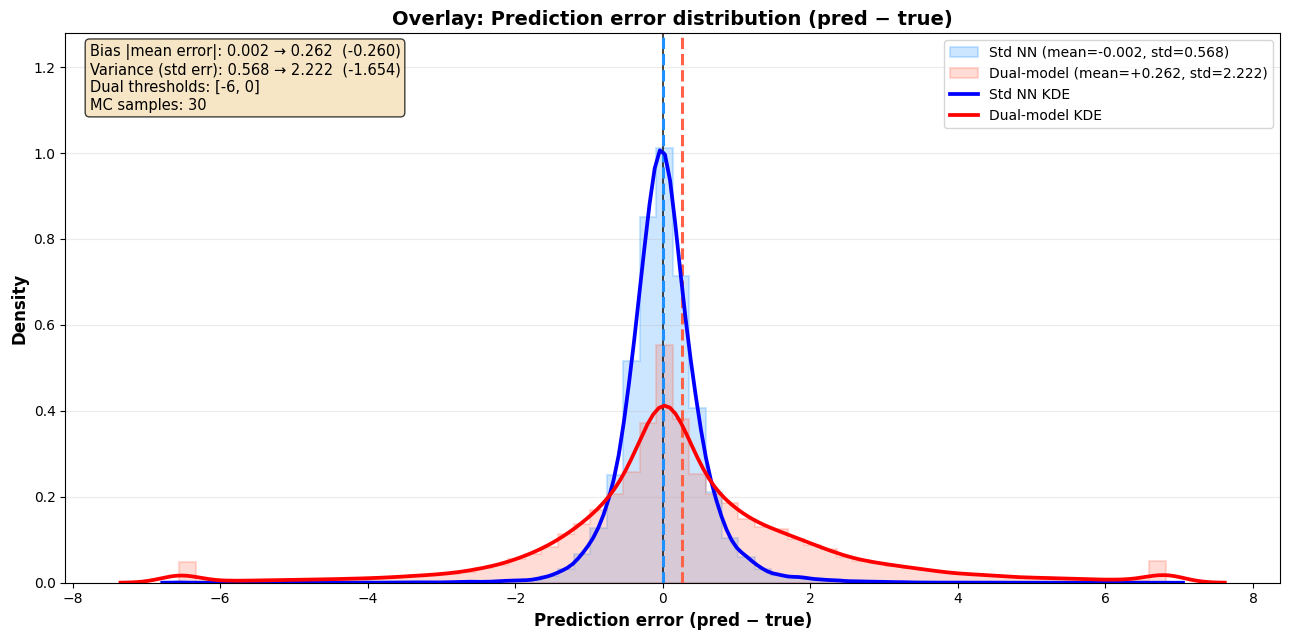

Saved: comparison_plots_from_csv\error_hist_overlay_pretty.png


In [6]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_error_hist_overlay_pretty_from_csv(
    csv_path: str,
    out_dir: str = 'comparison_plots_from_csv',
    out_name: str = 'error_hist_overlay_pretty.png',
    bins: int = 60,
    clip_pct: float = 0.5,
    kde: bool = True,
    kde_bw_adjust: float = 1.2,
    meta_path: str | None = None,
):
    df = pd.read_csv(csv_path)
    if 'err_std' not in df.columns or 'err_dual' not in df.columns:
        raise ValueError('CSV must contain err_std and err_dual columns')

    err_std = df['err_std'].to_numpy(dtype=float)
    err_dual = df['err_dual'].to_numpy(dtype=float)

    m = np.isfinite(err_std) & np.isfinite(err_dual)
    err_std, err_dual = err_std[m], err_dual[m]

    all_err = np.concatenate([err_std, err_dual])
    lo = np.percentile(all_err, clip_pct)
    hi = np.percentile(all_err, 100 - clip_pct)
    err_std_c = np.clip(err_std, lo, hi)
    err_dual_c = np.clip(err_dual, lo, hi)

    edges = np.histogram_bin_edges(np.concatenate([err_std_c, err_dual_c]), bins=bins)

    mu_s, sd_s = float(err_std.mean()), float(err_std.std(ddof=1))
    mu_d, sd_d = float(err_dual.mean()), float(err_dual.std(ddof=1))

    bias_change = abs(mu_s) - abs(mu_d)
    var_change = sd_s - sd_d

    # Optional: read thresholds etc for annotation
    thresholds = None
    n_mc = None
    if meta_path and os.path.exists(meta_path):
        with open(meta_path, 'r') as f:
            meta = json.load(f)
        thresholds = meta.get('dual_thresholds')
        n_mc = meta.get('n_mc')

    os.makedirs(out_dir, exist_ok=True)
    fig, ax = plt.subplots(figsize=(13, 6.5))

    ax.hist(
        err_std_c, bins=edges, density=True, histtype='stepfilled',
        alpha=0.22, color='dodgerblue', edgecolor='dodgerblue', linewidth=1.5,
        label=f"Std NN (mean={mu_s:+.3f}, std={sd_s:.3f})"
    )
    ax.hist(
        err_dual_c, bins=edges, density=True, histtype='stepfilled',
        alpha=0.22, color='tomato', edgecolor='tomato', linewidth=1.5,
        label=f"Dual-model (mean={mu_d:+.3f}, std={sd_d:.3f})"
    )

    ax.axvline(0.0, color='black', linewidth=1.2, alpha=0.85)
    ax.axvline(mu_s, color='dodgerblue', linestyle='--', linewidth=2.2)
    ax.axvline(mu_d, color='tomato', linestyle='--', linewidth=2.2)

    if kde:
        try:
            import seaborn as sns
            sns.kdeplot(err_std_c, ax=ax, color='blue', linewidth=2.7, bw_adjust=kde_bw_adjust, label='Std NN KDE')
            sns.kdeplot(err_dual_c, ax=ax, color='red', linewidth=2.7, bw_adjust=kde_bw_adjust, label='Dual-model KDE')
        except Exception:
            pass

    ax.set_title('Overlay: Prediction error distribution (pred − true)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Prediction error (pred − true)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Density', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.25, axis='y')

    ax.margins(y=0.15)
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax * 1.10)

    extra = ''
    if thresholds is not None:
        extra += f"\nDual thresholds: {thresholds}"
    if n_mc is not None:
        extra += f"\nMC samples: {n_mc}"

    ax.text(
        0.02, 0.98,
        f"Bias |mean error|: {abs(mu_s):.3f} → {abs(mu_d):.3f}  ({bias_change:+.3f})\n"
        f"Variance (std err): {sd_s:.3f} → {sd_d:.3f}  ({var_change:+.3f})" + extra,
        transform=ax.transAxes,
        ha='left', va='top',
        fontsize=10.5,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.75)
    )

    ax.legend(frameon=True)
    fig.tight_layout()

    out_path = os.path.join(out_dir, out_name)
    fig.savefig(out_path, dpi=170, bbox_inches='tight')
    plt.show()
    print(f"Saved: {out_path}")


if __name__ == '__main__':
    csv_dir = 'error_hist_csv'
    csv_path = os.path.join(csv_dir, 'errors.csv')
    meta_path = os.path.join(csv_dir, 'run_metadata.json')

    plot_error_hist_overlay_pretty_from_csv(
        csv_path=csv_path,
        out_dir='comparison_plots_from_csv',
        out_name='error_hist_overlay_pretty.png',
        bins=60,
        clip_pct=0.5,
        kde=True,
        kde_bw_adjust=1.2,
        meta_path=meta_path,
    )

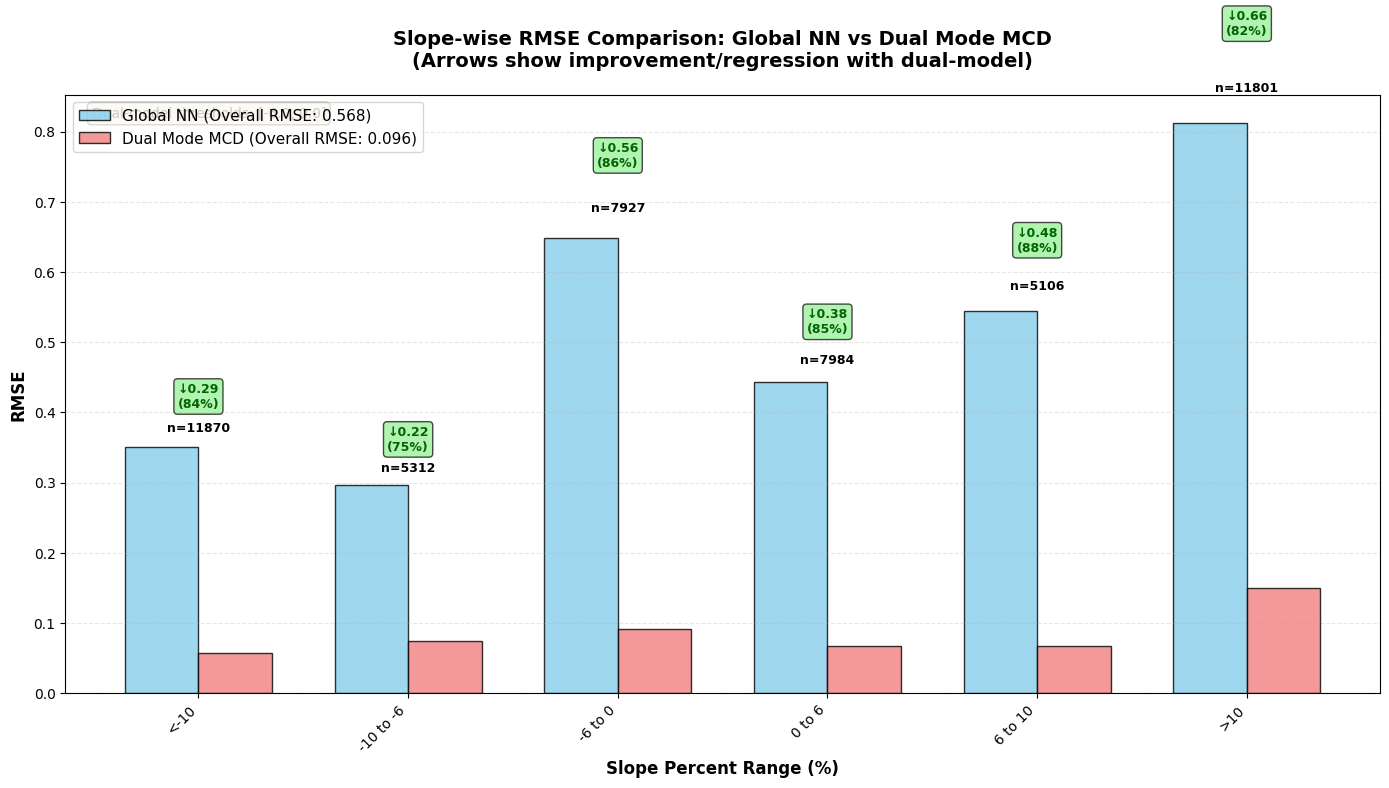

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')


def calculate_slope_wise_rmse(y_true, y_pred, slopes, slope_bins):
    bin_rmse = []
    bin_samples = []

    for i in range(len(slope_bins) - 1):
        mask = (slopes >= slope_bins[i]) & (slopes < slope_bins[i + 1])

        if np.sum(mask) > 0:
            y_true_bin = y_true[mask]
            y_pred_bin = y_pred[mask]

            valid_mask = ~np.isnan(y_pred_bin)
            if np.sum(valid_mask) > 1:
                y_true_bin = y_true_bin[valid_mask]
                y_pred_bin = y_pred_bin[valid_mask]

                bin_mse = mean_squared_error(y_true_bin, y_pred_bin)
                bin_rmse.append(np.sqrt(bin_mse))
                bin_samples.append(np.sum(mask))
            else:
                bin_rmse.append(np.nan)
                bin_samples.append(np.sum(mask))
        else:
            bin_rmse.append(np.nan)
            bin_samples.append(0)

    return bin_rmse, bin_samples


def plot_slope_wise_comparison(global_rmse_bins, dual_rmse_bins, bin_labels, bin_samples,
                               global_overall_rmse, dual_overall_rmse,
                               threshold_low, threshold_high, out_dir):
    plt.figure(figsize=(14, 8))

    valid_indices = []
    for i in range(len(bin_labels)):
        if bin_samples[i] > 0 and not np.isnan(global_rmse_bins[i]) and not np.isnan(dual_rmse_bins[i]):
            valid_indices.append(i)

    if not valid_indices:
        print("No valid bins found for plotting!")
        return

    valid_labels = [bin_labels[i] for i in valid_indices]
    valid_global_rmse = [global_rmse_bins[i] for i in valid_indices]
    valid_dual_rmse = [dual_rmse_bins[i] for i in valid_indices]
    valid_samples = [bin_samples[i] for i in valid_indices]

    x = np.arange(len(valid_labels))
    width = 0.35

    bars1 = plt.bar(
        x - width/2, valid_global_rmse, width,
        label=f'Global NN (Overall RMSE: {global_overall_rmse:.3f})',
        color='skyblue', edgecolor='black', alpha=0.8, zorder=1
    )
    bars2 = plt.bar(
        x + width/2, valid_dual_rmse, width,
        label=f'Dual Mode MCD (Overall RMSE: {dual_overall_rmse:.3f})',
        color='lightcoral', edgecolor='black', alpha=0.8, zorder=2
    )

    for i, (bar1, bar2, sample_count) in enumerate(zip(bars1, bars2, valid_samples)):
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        max_height = max(height1, height2)
        plt.text(x[i], max_height * 1.05, f'n={sample_count}',
                 ha='center', va='bottom', fontsize=9, fontweight='bold')

    for i, (g_rmse, d_rmse) in enumerate(zip(valid_global_rmse, valid_dual_rmse)):
        improvement = g_rmse - d_rmse
        improvement_pct = (improvement / g_rmse * 100) if g_rmse > 0 else 0
        y_pos = max(g_rmse, d_rmse) * 1.15

        if improvement > 0.01:
            plt.text(x[i], y_pos, f'↓{improvement:.2f}\n({improvement_pct:.0f}%)',
                     ha='center', va='bottom', fontsize=9, fontweight='bold',
                     color='darkgreen',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))
        elif improvement < -0.01:
            plt.text(x[i], y_pos, f'↑{abs(improvement):.2f}\n({abs(improvement_pct):.0f}%)',
                     ha='center', va='bottom', fontsize=9, fontweight='bold',
                     color='darkred',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7))

    threshold_str = f'Dual-model thresholds: [{threshold_low}, {threshold_high}]'
    plt.text(0.02, 0.98, threshold_str, transform=plt.gca().transAxes,
             fontsize=10, ha='left', va='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

    plt.xlabel('Slope Percent Range (%)', fontsize=12, fontweight='bold')
    plt.ylabel('RMSE', fontsize=12, fontweight='bold')
    plt.title('Slope-wise RMSE Comparison: Global NN vs Dual Mode MCD\n(Arrows show improvement/regression with dual-model)',
              fontsize=14, fontweight='bold', pad=20)

    plt.xticks(x, valid_labels, rotation=45, ha='right')
    plt.legend(loc='upper left', fontsize=11)
    plt.grid(True, alpha=0.3, linestyle='--', axis='y', zorder=0)

    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, 'slope_wise_rmse_comparison_from_csv.png'), dpi=150, bbox_inches='tight')
    plt.savefig(os.path.join(out_dir, 'slope_wise_rmse_comparison_from_csv.pdf'), bbox_inches='tight')
    plt.show()


def main():
    CSV_PATH = os.path.join("comparison_plots", "plot_data_global_vs_dual_mode_mcd.csv")
    OUT_DIR = "comparison_plots"
    os.makedirs(OUT_DIR, exist_ok=True)

    df = pd.read_csv(CSV_PATH)

    y_true = df["y_true"].to_numpy()
    global_pred = df["global_pred"].to_numpy()
    dual_pred = df["dual_mode_mcd_pred"].to_numpy()
    slopes = df["slope_percent"].to_numpy()

    global_overall_rmse = float(df["global_rmse"].iloc[0])
    dual_overall_rmse = float(df["dual_mode_mcd_rmse"].iloc[0])
    threshold_low = float(df["threshold_low"].iloc[0])
    threshold_high = float(df["threshold_high"].iloc[0])

    slope_bins = [-float('inf'), -10, -6, 0, 6, 10, float('inf')]
    bin_labels = ['<-10', '-10 to -6', '-6 to 0', '0 to 6', '6 to 10', '>10']

    global_bin_rmse, bin_samples = calculate_slope_wise_rmse(
        y_true, global_pred, slopes, slope_bins
    )
    dual_bin_rmse, _ = calculate_slope_wise_rmse(
        y_true, dual_pred, slopes, slope_bins
    )

    plot_slope_wise_comparison(
        global_bin_rmse, dual_bin_rmse, bin_labels, bin_samples,
        global_overall_rmse, dual_overall_rmse,
        threshold_low, threshold_high, OUT_DIR
    )


if __name__ == "__main__":
    main()
